# EDA - Dados Importação

---
## 1.0 - Importação das bibiliotecas e leitura inicial da base

In [1]:
# Libs padrões para manipulação de dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Libs para MLs
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report

# Melhorar o modelo de RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

# Melhorar o modelo de RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# Leitura da base com o delimitador
df_importacao = pd.read_csv(
    "C:\\Users\\lucas\\OneDrive\\Desktop\\Estudos Python\\POS\\API_Embrapa\\downloads\\ImpVinhos.csv",
    sep=';',        # Delimitador correto
    encoding='utf-8',
    skiprows=1,     # Ignorar a primeira linha, se necessário
    header=None     # Sem cabeçalhos no arquivo
)

# Leitura da base

df_importacao.head()

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
0,1,Africa do Sul,0,0.0,0,0,0,0,0,0,...,1092042,3604038,627150,1701072,859169,2508140,738116,2266827,522733,1732850
1,2,Alemanha,52297,30498.0,34606,26027,134438,92103,111523,98638,...,101055,412794,136992,504168,106541,546967,92600,438595,102456,557947
2,3,Argélia,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Arábia Saudita,0,0.0,0,0,0,0,0,0,...,0,0,0,0,2510,8761,0,0,8,161
4,5,Argentina,19525,12260.0,24942,15022,104906,58137,116887,76121,...,16548931,54527380,22610267,66322932,26869241,79527959,27980574,87519642,25276991,83918138


In [3]:
# Verificando o tamanho da base
df_importacao.shape

(68, 110)

Tabela esta toda fora de formatação, estou com ajuda do CoPilot para executar o trabalho. Terei que formatar os dados, e depois irei iniciar um tratamento de dados faltantes.

---
## 2.0 - Tratamento da Base

---
### 2.1 - Ajuste e estrutução da base

In [4]:
# Renomear as colunas manualmente
colunas = ["Id", "País"] + [
    f"{year}_{suffix}" for year in range(1970, 2025) for suffix in ["Quantidade", "Valor"]
]
df_importacao.columns = colunas[:len(df_importacao.columns)]

# Verificar a estrutura do DataFrame
print("Estrutura inicial do DataFrame após renomeação:")
print(df_importacao.head())
print("Número de colunas:", len(df_importacao.columns))

# Transformar os dados para o formato "long"
df_long = pd.melt(
    df_importacao,
    id_vars=["Id", "País"],
    var_name="Ano_Tipo",
    value_name="Valor"
)

# Separar a coluna "Ano_Tipo" em "Ano" e "Tipo"
df_long[["Ano", "Tipo"]] = df_long["Ano_Tipo"].str.split("_", expand=True)

# Pivotar os dados
df_final = df_long.pivot_table(
    index=["Id", "País", "Ano"],
    columns="Tipo",
    values="Valor",
    aggfunc="first"
).reset_index()

# Renomear as colunas
df_final.columns.name = None
df_final.rename(columns={"Quantidade": "Quantidade (Kg)", "Valor": "Valor (US$)"}, inplace=True)

# Exibir o DataFrame final
print("DataFrame final:")
print(df_final.head())

Estrutura inicial do DataFrame após renomeação:
   Id            País  1970_Quantidade  1970_Valor  1971_Quantidade  \
0   1   Africa do Sul                0         0.0                0   
1   2        Alemanha            52297     30498.0            34606   
2   3         Argélia                0         0.0                0   
3   4  Arábia Saudita                0         0.0                0   
4   5       Argentina            19525     12260.0            24942   

   1971_Valor  1972_Quantidade  1972_Valor  1973_Quantidade  1973_Valor  ...  \
0           0                0           0                0           0  ...   
1       26027           134438       92103           111523       98638  ...   
2           0                0           0                0           0  ...   
3           0                0           0                0           0  ...   
4       15022           104906       58137           116887       76121  ...   

   2019_Quantidade  2019_Valor  2020_Quantid

In [5]:
# Verifica DF após alterações
df_final

,Id,País,Ano,Quantidade (Kg),Valor (US$)
0,1,Africa do Sul,1970,0.0,0.0
1,1,Africa do Sul,1971,0.0,0.0
2,1,Africa do Sul,1972,0.0,0.0
3,1,Africa do Sul,1973,0.0,0.0
4,1,Africa do Sul,1974,0.0,0.0
...,...,...,...,...,...
3667,68,Outros,2019,0.0,0.0
3668,68,Outros,2020,0.0,0.0
3669,68,Outros,2021,0.0,0.0
3670,68,Outros,2022,0.0,0.0


In [6]:
# Verifica se o DataFrame final tem o mesmo número de linhas que o original
print("Número de linhas no DataFrame final:", len(df_final))
print("Número de combinações únicas de País e Ano:", df_final[[ "País", "Ano"]].shape[0])

Número de linhas no DataFrame final: 3672
Número de combinações únicas de País e Ano: 3672


In [7]:
print("Resumo estatístico de Quantidade (Kg):")
print(df_final["Quantidade (Kg)"].describe())

print("Resumo estatístico de Valor (US$):")
print(df_final["Valor (US$)"].describe())

Resumo estatístico de Quantidade (Kg):
count    3.672000e+03
mean     5.804332e+05
std      3.660353e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+00
max      7.272619e+07
Name: Quantidade (Kg), dtype: float64
Resumo estatístico de Valor (US$):
count    3.671000e+03
mean     1.642505e+06
std      1.035151e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.300000e+01
max      1.843353e+08
Name: Valor (US$), dtype: float64


In [8]:
# Verifica se o DF esta completo, e não somou os valores (paises)
pais_especifico = "Outros"  # Substitua pelo país que deseja verificar
df_pais = df_final[df_final["País"] == pais_especifico]
print(f"Dados para o país {pais_especifico}:")
print(df_pais)

Dados para o país Outros:
      Id    País   Ano  Quantidade (Kg)  Valor (US$)
3618  68  Outros  1970           5508.0       4255.0
3619  68  Outros  1971          77789.0      42028.0
3620  68  Outros  1972          79052.0      25032.0
3621  68  Outros  1973           4306.0       5775.0
3622  68  Outros  1974          21501.0      28163.0
3623  68  Outros  1975          18132.0      13989.0
3624  68  Outros  1976          10200.0       7884.0
3625  68  Outros  1977            450.0        642.0
3626  68  Outros  1978           1347.0       1210.0
3627  68  Outros  1979           2411.0       2614.0
3628  68  Outros  1980          10446.0      10543.0
3629  68  Outros  1981          17133.0      17869.0
3630  68  Outros  1982          22104.0      30505.0
3631  68  Outros  1983           6738.0       5862.0
3632  68  Outros  1984          26490.0      34499.0
3633  68  Outros  1985           5400.0      12812.0
3634  68  Outros  1986          15717.0      18768.0
3635  68  Outros  19

In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               3672 non-null   int64  
 1   País             3672 non-null   object 
 2   Ano              3672 non-null   object 
 3   Quantidade (Kg)  3672 non-null   float64
 4   Valor (US$)      3671 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 143.6+ KB


Ajustes feito com sucesso, foi bastante trabalhaso. Visto que a base esta vindo perdendo toda a formatação.

- Excluir a coluna ID, pois nao agrega;
- Converter o Ano para Int

---
### 2.2 - Ajuste fino na base

- Apagar colunas que não agregam
- Apagar linhas vazias

In [10]:
# Apaga coluna Id no DataFrame original
df_final.drop(columns=["Id"], inplace=True)

# Verificar o resultado
print(df_final.head())

            País   Ano  Quantidade (Kg)  Valor (US$)
0  Africa do Sul  1970              0.0          0.0
1  Africa do Sul  1971              0.0          0.0
2  Africa do Sul  1972              0.0          0.0
3  Africa do Sul  1973              0.0          0.0
4  Africa do Sul  1974              0.0          0.0


In [11]:
# Converter para int, tratando valores inválidos
df_final["Ano"] = pd.to_numeric(df_final["Ano"], errors="coerce").astype(int)

In [12]:
# Verifica alteração da coluna Ano
print("Tipo da coluna 'Ano' após conversão:")
print(df_final["Ano"].dtype)

Tipo da coluna 'Ano' após conversão:
int64


In [13]:
# Filtrar linhas onde ambas as colunas possuem o valor 0.0
linhas_zero = df_final[(df_final["Quantidade (Kg)"] == 0.0) & (df_final["Valor (US$)"] == 0.0)]

# Exibir as linhas filtradas
print("Linhas onde 'Quantidade (Kg)' e 'Valor (US$)' possuem o valor 0.0:")
print(linhas_zero)

Linhas onde 'Quantidade (Kg)' e 'Valor (US$)' possuem o valor 0.0:
               País   Ano  Quantidade (Kg)  Valor (US$)
0     Africa do Sul  1970              0.0          0.0
1     Africa do Sul  1971              0.0          0.0
2     Africa do Sul  1972              0.0          0.0
3     Africa do Sul  1973              0.0          0.0
4     Africa do Sul  1974              0.0          0.0
...             ...   ...              ...          ...
3667         Outros  2019              0.0          0.0
3668         Outros  2020              0.0          0.0
3669         Outros  2021              0.0          0.0
3670         Outros  2022              0.0          0.0
3671         Outros  2023              0.0          0.0

[2740 rows x 4 columns]


- Caso eu apague as linhas com valores zerados, eu terei uma perca significativa (-79%) dos dados;

Optei por manter os dados, e converte-los para NaN. Evitando problemas em calculos estatisticos. E manter os dados pode ajudar na analise temporal de tendencias.

In [14]:
# Substituir valores 0.0 por NaN
df_final.loc[(df_final["Quantidade (Kg)"] == 0.0) & (df_final["Valor (US$)"] == 0.0), ["Quantidade (Kg)", "Valor (US$)"]] = None

---
## 3.0 - Analises graficas

C:\Users\lucas\AppData\Local\Temp\ipykernel_28112\3692396046.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_paises_valor.index, y=top_paises_valor["Valor (US$)"], palette="Blues_d")


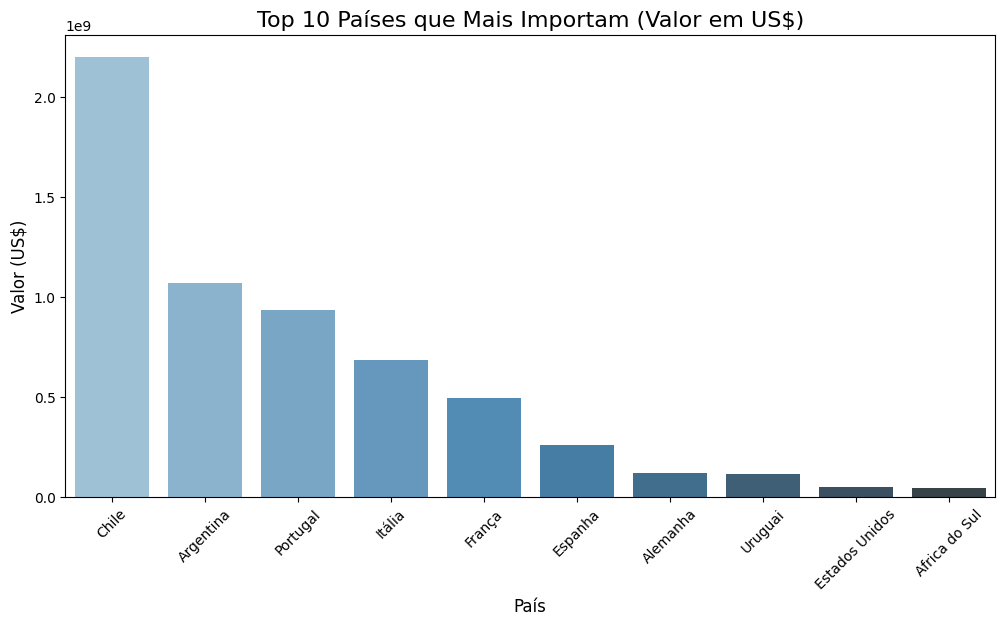

C:\Users\lucas\AppData\Local\Temp\ipykernel_28112\3692396046.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_paises_quantidade.index, y=top_paises_quantidade["Quantidade (Kg)"], palette="Greens_d")


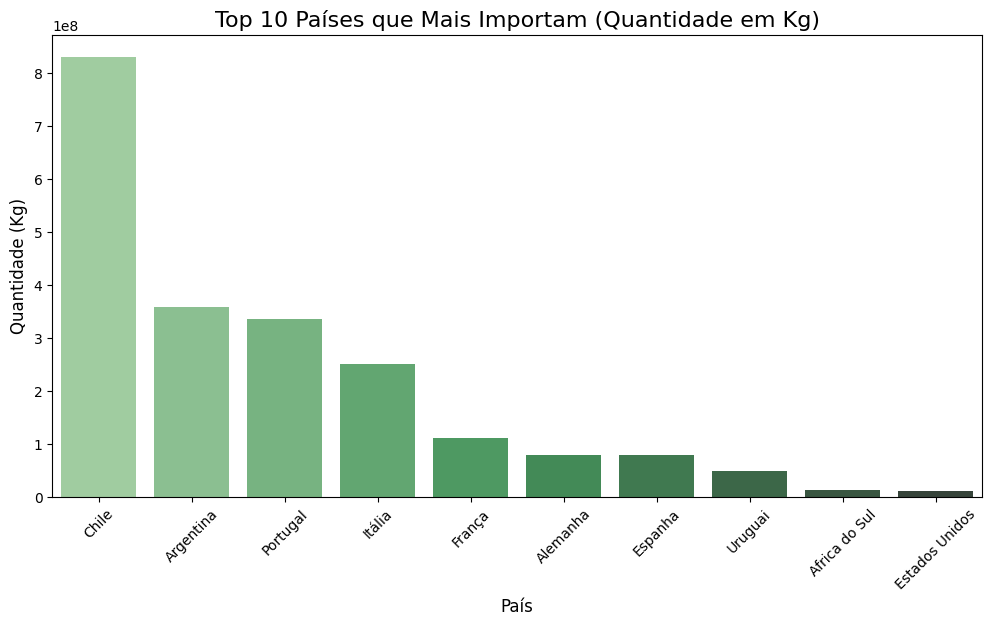

In [15]:
# Agrupar por país e somar os valores
importacao_por_pais = df_final.groupby("País")[["Quantidade (Kg)", "Valor (US$)"]].sum().sort_values(by="Valor (US$)", ascending=False)

# Top 10 países que mais importam (em valor)
top_paises_valor = importacao_por_pais.head(10)

# Gráfico de barras para os países que mais importam em valor
plt.figure(figsize=(12, 6))
sns.barplot(x=top_paises_valor.index, y=top_paises_valor["Valor (US$)"], palette="Blues_d")
plt.title("Top 10 Países que Mais Importam (Valor em US$)", fontsize=16)
plt.ylabel("Valor (US$)", fontsize=12)
plt.xlabel("País", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Top 10 países que mais importam (em quantidade)
top_paises_quantidade = importacao_por_pais.sort_values(by="Quantidade (Kg)", ascending=False).head(10)

# Gráfico de barras para os países que mais importam em quantidade
plt.figure(figsize=(12, 6))
sns.barplot(x=top_paises_quantidade.index, y=top_paises_quantidade["Quantidade (Kg)"], palette="Greens_d")
plt.title("Top 10 Países que Mais Importam (Quantidade em Kg)", fontsize=16)
plt.ylabel("Quantidade (Kg)", fontsize=12)
plt.xlabel("País", fontsize=12)
plt.xticks(rotation=45)
plt.show()

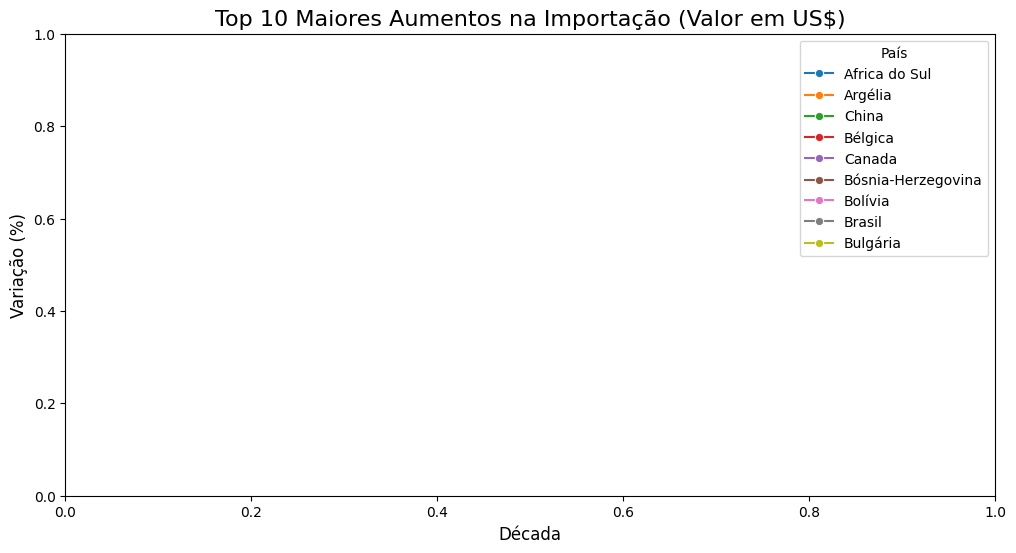

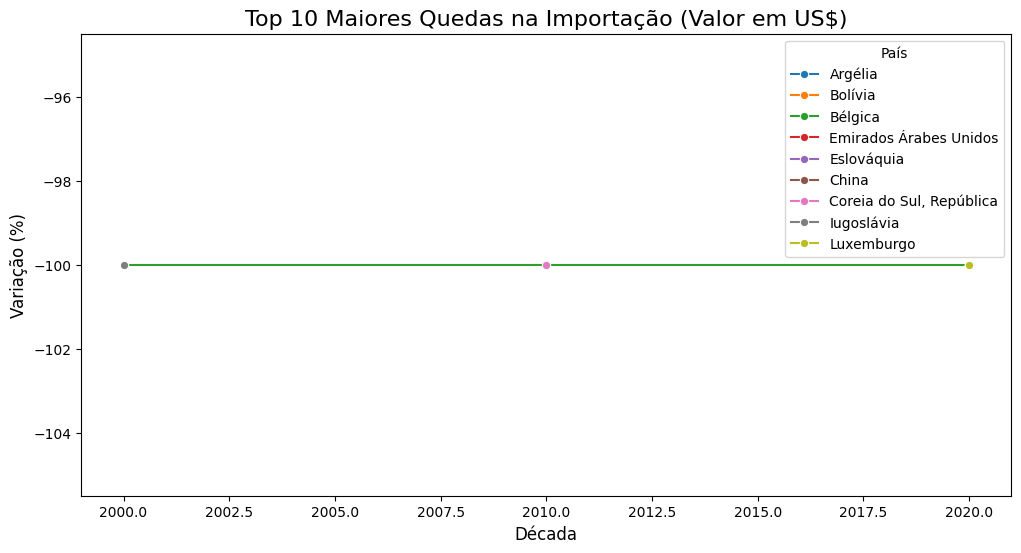

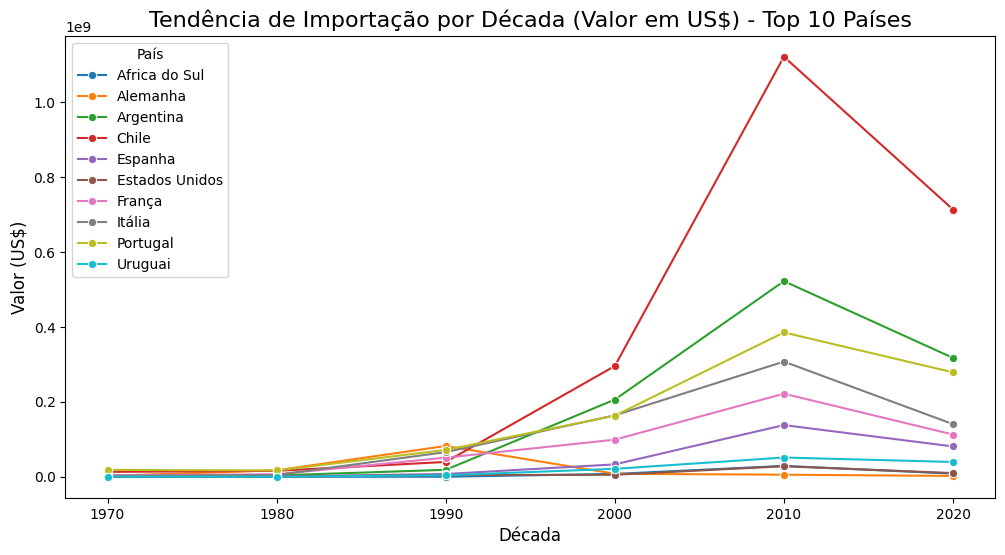

In [16]:
# Criar um novo DataFrame com a coluna de décadas
df_decadas = df_final.copy()
df_decadas["Década"] = (df_decadas["Ano"] // 10) * 10

# Agrupar por país e década, somando os valores
importacao_por_decada = df_decadas.groupby(["País", "Década"])[["Quantidade (Kg)", "Valor (US$)"]].sum().reset_index()

# Calcular a variação percentual por país
importacao_por_decada["Variação_Quantidade"] = importacao_por_decada.groupby("País")["Quantidade (Kg)"].pct_change() * 100
importacao_por_decada["Variação_Valor"] = importacao_por_decada.groupby("País")["Valor (US$)"].pct_change() * 100

# Países com maior aumento na importação (em valor)
maior_aumento_valor = importacao_por_decada.sort_values(by="Variação_Valor", ascending=False).head(10)

# Gráfico de linha para os maiores aumentos em valor
plt.figure(figsize=(12, 6))
sns.lineplot(data=maior_aumento_valor, x="Década", y="Variação_Valor", hue="País", marker="o")
plt.title("Top 10 Maiores Aumentos na Importação (Valor em US$)", fontsize=16)
plt.ylabel("Variação (%)", fontsize=12)
plt.xlabel("Década", fontsize=12)
plt.legend(title="País")
plt.show()

# Países com maior queda na importação (em valor)
maior_queda_valor = importacao_por_decada.sort_values(by="Variação_Valor").head(10)

# Gráfico de linha para as maiores quedas em valor
plt.figure(figsize=(12, 6))
sns.lineplot(data=maior_queda_valor, x="Década", y="Variação_Valor", hue="País", marker="o")
plt.title("Top 10 Maiores Quedas na Importação (Valor em US$)", fontsize=16)
plt.ylabel("Variação (%)", fontsize=12)
plt.xlabel("Década", fontsize=12)
plt.legend(title="País")
plt.show()

# Gráfico de linha para tendências de importação por década (Top 10 países)
top_10_paises = df_final.groupby("País")["Valor (US$)"].sum().sort_values(ascending=False).head(10).index
dados_top_10_decadas = importacao_por_decada[importacao_por_decada["País"].isin(top_10_paises)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=dados_top_10_decadas, x="Década", y="Valor (US$)", hue="País", marker="o")
plt.title("Tendência de Importação por Década (Valor em US$) - Top 10 Países", fontsize=16)
plt.ylabel("Valor (US$)", fontsize=12)
plt.xlabel("Década", fontsize=12)
plt.legend(title="País")
plt.show()

<Figure size 1200x600 with 0 Axes>

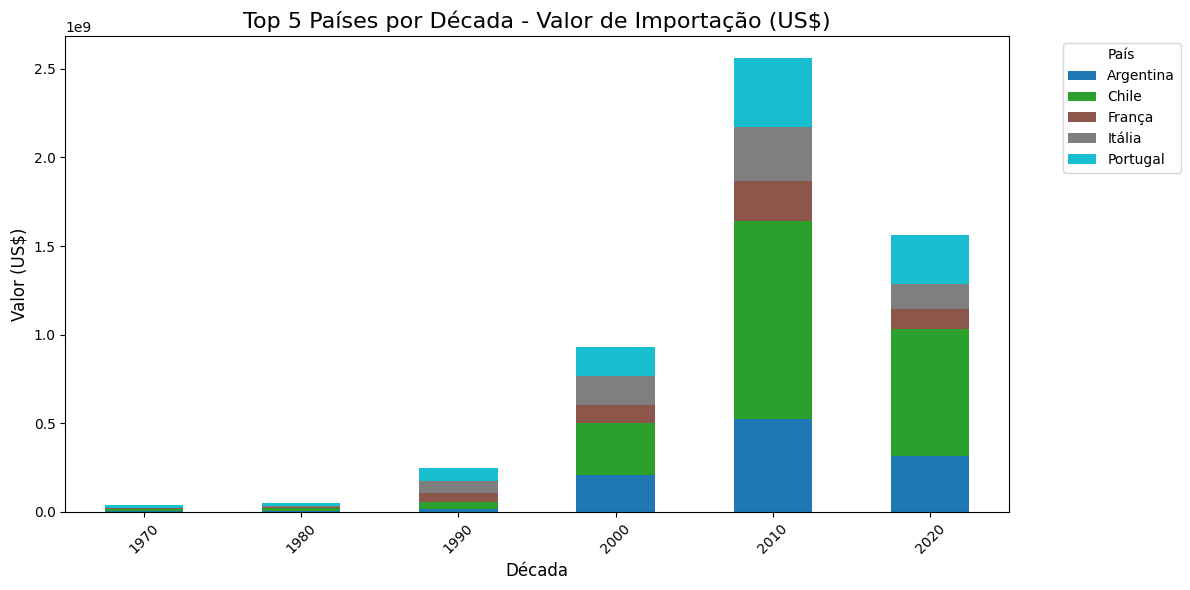

In [17]:
# Criar um novo DataFrame com a coluna de décadas
df_decadas = df_final.copy()
df_decadas["Década"] = (df_decadas["Ano"] // 10) * 10

# Agrupar por país e década, somando os valores
importacao_por_decada = df_decadas.groupby(["País", "Década"])[["Valor (US$)"]].sum().reset_index()

# Selecionar os Top 5 países com maior valor total de importação
top_5_paises = importacao_por_decada.groupby("País")["Valor (US$)"].sum().sort_values(ascending=False).head(5).index

# Filtrar os dados para os Top 5 países
dados_top_5 = importacao_por_decada[importacao_por_decada["País"].isin(top_5_paises)]

# Pivotar os dados para criar o formato necessário para barras empilhadas
dados_pivot = dados_top_5.pivot(index="Década", columns="País", values="Valor (US$)").fillna(0)

# Criar o gráfico de barras empilhadas
plt.figure(figsize=(12, 6))
dados_pivot.plot(kind="bar", stacked=True, colormap="tab10", figsize=(12, 6))

# Configurar o título e os rótulos
plt.title("Top 5 Países por Década - Valor de Importação (US$)", fontsize=16)
plt.ylabel("Valor (US$)", fontsize=12)
plt.xlabel("Década", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="País", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Exibir o gráfico
plt.show()

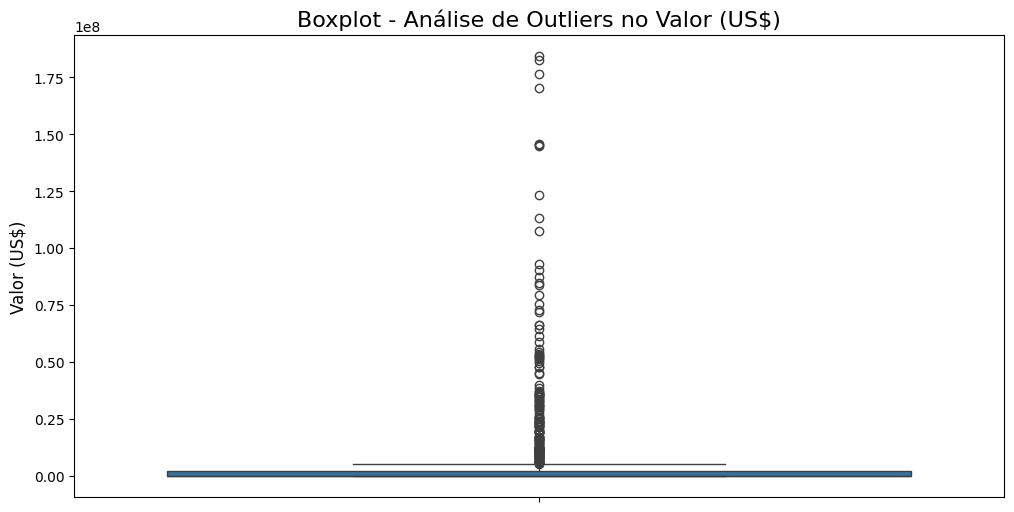

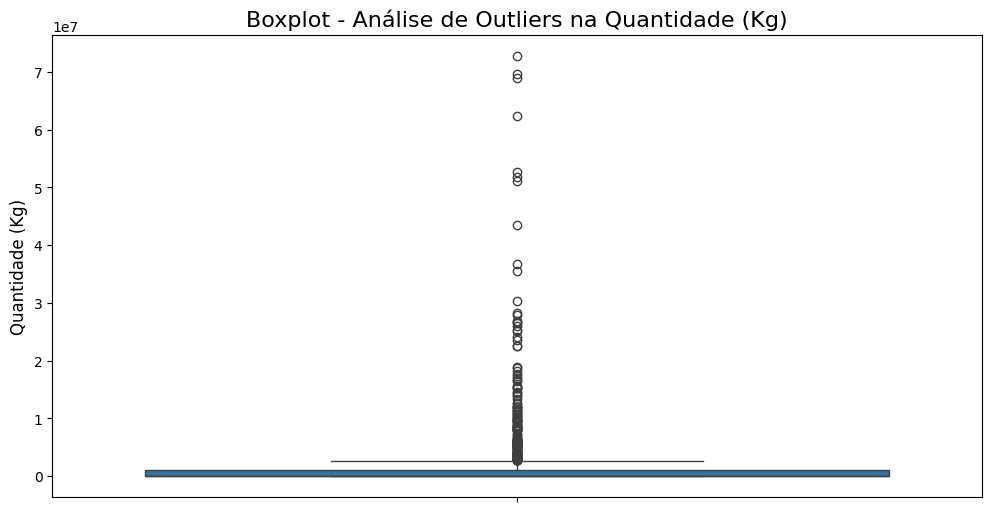

In [18]:
# Remover valores NaN das colunas antes de gerar os gráficos
df_valor_sem_nan = df_final.dropna(subset=["Valor (US$)"])
df_quantidade_sem_nan = df_final.dropna(subset=["Quantidade (Kg)"])

# Gráfico de boxplot para análise de outliers no Valor (US$)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_valor_sem_nan, y="Valor (US$)")
plt.title("Boxplot - Análise de Outliers no Valor (US$)", fontsize=16)
plt.ylabel("Valor (US$)", fontsize=12)
plt.show()

# Gráfico de boxplot para análise de outliers na Quantidade (Kg)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_quantidade_sem_nan, y="Quantidade (Kg)")
plt.title("Boxplot - Análise de Outliers na Quantidade (Kg)", fontsize=16)
plt.ylabel("Quantidade (Kg)", fontsize=12)
plt.show()

---
## 4.0 - Implementação de Featuring Engineer

In [19]:
# Nova variavel para o modelo de ML, tirando valores nulos
df_ml = df_final.dropna(subset=["Quantidade (Kg)", "Valor (US$)"])
print(df_ml.info())

<class 'pandas.core.frame.DataFrame'>
Index: 931 entries, 31 to 3653
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   País             931 non-null    object 
 1   Ano              931 non-null    int64  
 2   Quantidade (Kg)  931 non-null    float64
 3   Valor (US$)      931 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 36.4+ KB
None


In [20]:
# Remover outliers com base no intervalo interquartil (IQR)
Q1 = df_ml["Valor (US$)"].quantile(0.25)
Q3 = df_ml["Valor (US$)"].quantile(0.75)
IQR = Q3 - Q1

# Filtrar dados dentro de 1.5 * IQR
df_ml = df_ml[~((df_ml["Valor (US$)"] < (Q1 - 1.5 * IQR)) | (df_ml["Valor (US$)"] > (Q3 + 1.5 * IQR)))]

In [21]:
# Aplicar transformação logarítmica
df_ml["Valor (US$)"] = np.log1p(df_ml["Valor (US$)"])
df_ml["Quantidade (Kg)"] = np.log1p(df_ml["Quantidade (Kg)"])

In [22]:
# Criar uma nova coluna de década
df_ml["Década"] = (df_ml["Ano"] // 10) * 10

# Criar interações
df_ml["Ano_Quantidade"] = df_ml["Ano"] * df_ml["Quantidade (Kg)"]

In [23]:
# Verificar países únicos
paises_unicos = df_final["País"].unique()
print(f"Número de países únicos: {len(paises_unicos)}")
print("Lista de países únicos:", paises_unicos)

Número de países únicos: 68
Lista de países únicos: ['Africa do Sul' 'Alemanha' 'Argélia' 'Arábia Saudita' 'Argentina'
 'Armênia' 'Austrália' 'Áustria' 'Bermudas' 'Bélgica' 'Bolívia'
 'Bósnia-Herzegovina' 'Brasil' 'Bulgária' 'Canada' 'Chile' 'China'
 'Coreia do Sul, República' 'Croácia' 'Cuba' 'Emirados Árabes Unidos'
 'Eslovênia' 'Eslováquia' 'Espanha' 'Estados Unidos' 'França' 'Geórgia'
 'Geórgia do Sul e Sandwich do Sul, Ilhas' 'Grécia' 'Hong Kong' 'Hungria'
 'Indonésia' 'Irlanda' 'Israel' 'Itália' 'Japão' 'Iugoslávia' 'Líbano'
 'Luxemburgo' 'Macedônia' 'Marrocos' 'México' 'Moldávia' 'Montenegro'
 'Noruega' 'Nova Zelândia' 'Países Baixos (Holanda)' 'Panamá' 'Peru'
 'Porto Rico' 'Portugal' 'Reino Unido' 'Republica Dominicana' 'Romênia'
 'Rússia' 'San Marino' 'Sérvia' 'Síria' 'Suazilândia' 'Suíça'
 'Tcheca, República' 'Tunísia' 'Turquia' 'Ucrânia' 'Uruguai'
 'Não consta na tabela' 'Não declarados' 'Outros']


In [24]:
# Mapeamento manual de países para continentes
pais_para_continente = {
    "Africa do Sul": "África",
    "Alemanha": "Europa",
    "Argélia": "África",
    "Arábia Saudita": "Ásia",
    "Argentina": "América do Sul",
    "Armênia": "Ásia",
    "Austrália": "Oceania",
    "Áustria": "Europa",
    "Bermudas": "América do Norte",
    "Bélgica": "Europa",
    "Bolívia": "América do Sul",
    "Bósnia-Herzegovina": "Europa",
    "Brasil": "América do Sul",
    "Bulgária": "Europa",
    "Canada": "América do Norte",
    "Chile": "América do Sul",
    "China": "Ásia",
    "Coreia do Sul, República": "Ásia",
    "Croácia": "Europa",
    "Cuba": "América do Norte",
    "Emirados Árabes Unidos": "Ásia",
    "Eslovênia": "Europa",
    "Eslováquia": "Europa",
    "Espanha": "Europa",
    "Estados Unidos": "América do Norte",
    "França": "Europa",
    "Geórgia": "Ásia",
    "Geórgia do Sul e Sandwich do Sul, Ilhas": "América do Sul",
    "Grécia": "Europa",
    "Hong Kong": "Ásia",
    "Hungria": "Europa",
    "Indonésia": "Ásia",
    "Irlanda": "Europa",
    "Israel": "Ásia",
    "Itália": "Europa",
    "Japão": "Ásia",
    "Iugoslávia": "Europa",
    "Líbano": "Ásia",
    "Luxemburgo": "Europa",
    "Macedônia": "Europa",
    "Marrocos": "África",
    "México": "América do Norte",
    "Moldávia": "Europa",
    "Montenegro": "Europa",
    "Noruega": "Europa",
    "Nova Zelândia": "Oceania",
    "Países Baixos (Holanda)": "Europa",
    "Panamá": "América do Norte",
    "Peru": "América do Sul",
    "Porto Rico": "América do Norte",
    "Portugal": "Europa",
    "Reino Unido": "Europa",
    "Republica Dominicana": "América do Norte",
    "Romênia": "Europa",
    "Rússia": "Europa",
    "San Marino": "Europa",
    "Sérvia": "Europa",
    "Síria": "Ásia",
    "Suazilândia": "África",
    "Suíça": "Europa",
    "Tcheca, República": "Europa",
    "Tunísia": "África",
    "Turquia": "Ásia",
    "Ucrânia": "Europa",
    "Uruguai": "América do Sul",
    "Não consta na tabela": "Desconhecido",
    "Não declarados": "Desconhecido",
    "Outros": "Desconhecido"
}

# Aplicar o mapeamento ao DataFrame
df_ml["Continente"] = df_ml["País"].map(pais_para_continente)

# Verificar o resultado
print(df_ml[["País", "Continente"]].head())

             País Continente
31  Africa do Sul     África
32  Africa do Sul     África
33  Africa do Sul     África
34  Africa do Sul     África
35  Africa do Sul     África


<Axes: xlabel='Continente'>

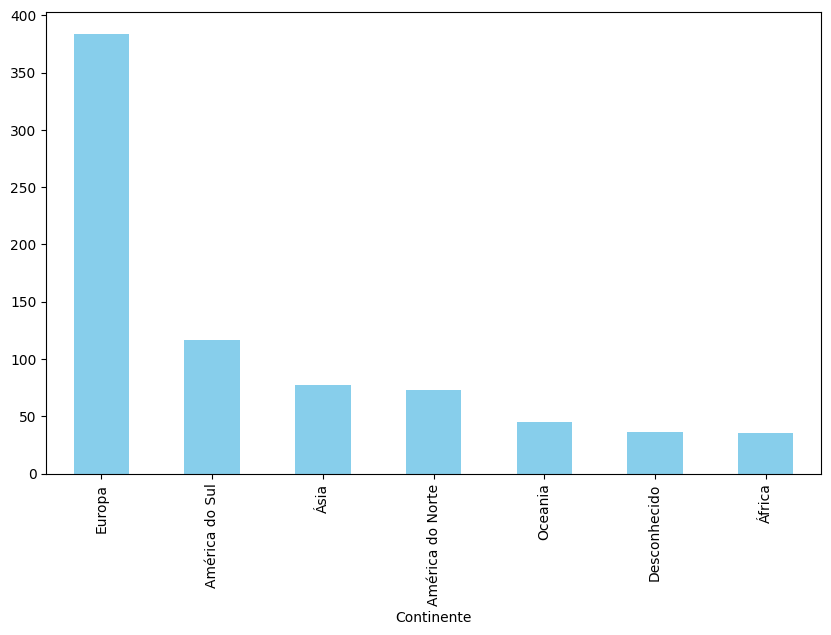

In [25]:
df_ml['Continente'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue')

In [26]:
# Resetar os índices para uma sequência numérica
df_ml = df_ml.reset_index(drop=True)

# Verificar o resultado
print(df_ml.head())

            País   Ano  Quantidade (Kg)  Valor (US$)  Década  Ano_Quantidade  \
0  Africa do Sul  2001        10.661064    11.504913    2000    21332.788810   
1  Africa do Sul  2002        10.379566    11.574190    2000    20779.892013   
2  Africa do Sul  2003        11.965529    12.630366    2000    23966.953745   
3  Africa do Sul  2004        12.623104    13.407696    2000    25296.700296   
4  Africa do Sul  2005        12.917585    13.561163    2000    25899.758219   

  Continente  
0     África  
1     África  
2     África  
3     África  
4     África  


In [27]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   País             767 non-null    object 
 1   Ano              767 non-null    int64  
 2   Quantidade (Kg)  767 non-null    float64
 3   Valor (US$)      767 non-null    float64
 4   Década           767 non-null    int64  
 5   Ano_Quantidade   767 non-null    float64
 6   Continente       767 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 42.1+ KB


In [28]:
# Salvar o DataFrame tratado após o feature engineering
output_path = "c:\\Users\\lucas\\OneDrive\\Desktop\\Estudos Python\\POS\\API_Embrapa\\data\\processed\\importacao_dados_transformados.csv"
df_ml.to_csv(output_path, index=False, encoding="utf-8")
print(f"Arquivo tratado salvo em: {output_path}")

Arquivo tratado salvo em: c:\Users\lucas\OneDrive\Desktop\Estudos Python\POS\API_Embrapa\data\processed\importacao_dados_transformados.csv


---
## 5.0 - Implementação de modelos de ML

---
### 5.1 - Random Forrest Classifier - Analise do Valor

In [29]:
# Separar variáveis independentes (X) e dependente (y)
X = df_ml[["Ano", "Quantidade (Kg)", "Ano_Quantidade", "Década"]]
y = df_ml["Valor (US$)"]

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.4401997077170215
R²: 0.9402906911253088


In [30]:
# Hiperparâmetros para otimização
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# GridSearchCV para encontrar os melhores parâmetros
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # Validação cruzada com 5 folds
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_

# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)
print("Melhores parâmetros:", grid_search.best_params_)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

Melhores parâmetros: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
MSE: 0.41165920626731345
R²: 0.9441619649735747


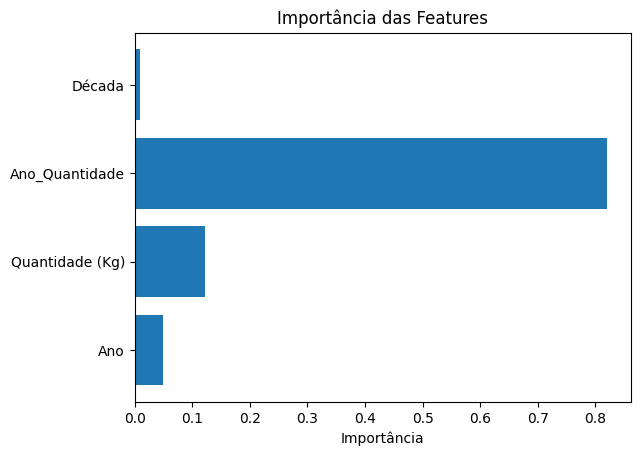

In [31]:
importances = model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.xlabel("Importância")
plt.title("Importância das Features")
plt.show()